Loading data...
Preprocessing & Feature Engineering...
Training set shape: (1037340, 17)
Test set shape: (259335, 17)
Fraud ratio in Train: 0.5789%

TRAINING ENSEMBLE MODEL (XGBoost + LightGBM + CatBoost)
Calculated scale_pos_weight: 171.75
Fitting Ensemble Model...
Predicting probabilities...

>>> Optimal Threshold Found: 0.9657
>>> Best F1-Score at threshold: 0.8841

FINAL EVALUATION REPORT
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    257834
       Fraud       0.93      0.84      0.88      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.92      0.94    259335
weighted avg       1.00      1.00      1.00    259335

ROC-AUC Score: 0.9990
PR-AUC Score:  0.9371


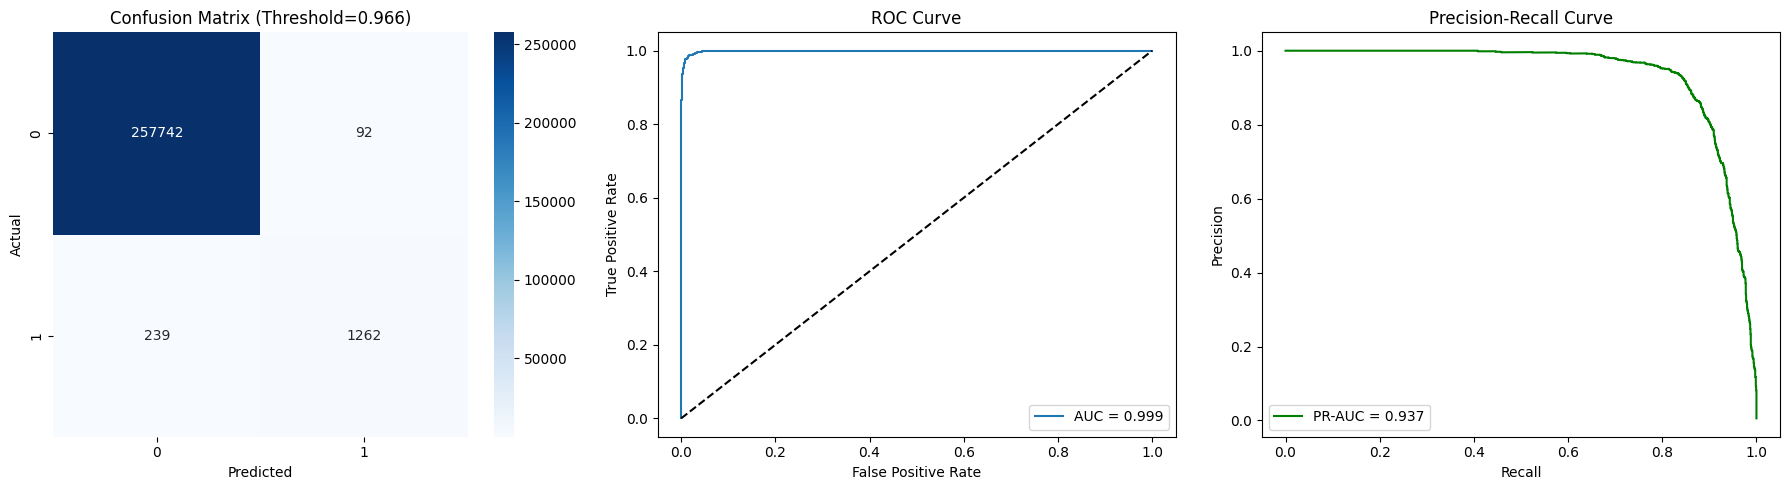


SAVING MODEL
Model, threshold, and feature list saved to: fraud_detection_model.pkl


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, precision_recall_curve, auc, 
                             confusion_matrix, classification_report)
from sklearn.ensemble import VotingClassifier

# Boosting Models (State-of-the-art for Tabular Data)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib # Thêm thư viện này để lưu/load model

warnings.filterwarnings('ignore')

# ============================================================================
# 1. ADVANCED FEATURE ENGINEERING (Tạo đặc trưng hành vi)
# ============================================================================

def create_features(df):
    """
    Tạo các features tập trung vào sự bất thường trong hành vi tiêu dùng
    """
    df = df.copy()
    
    # --- 1. Xử lý thời gian ---
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    
    # Tuổi khách hàng
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
    
    # --- 2. Khoảng cách địa lý (Haversine approximation) ---
    # Khoảng cách từ người mua đến merchant
    df['distance_km'] = np.sqrt(
        (df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2
    ) * 111
    
    # --- 3. Transaction Aggregations (Quan trọng nhất cho Fraud) ---
    # Tính toán hành vi trung bình của thẻ này trong quá khứ
    
    # Sắp xếp theo thời gian để tránh data leakage (nếu dùng rolling window)
    # Ở đây dùng groupby transform cho đơn giản và hiệu quả
    
    # Trung bình số tiền giao dịch của thẻ này
    df['card_mean_amt'] = df.groupby('cc_num')['amt'].transform('mean')
    df['card_std_amt'] = df.groupby('cc_num')['amt'].transform('std')
    
    # Giao dịch hiện tại lệch bao nhiêu so với trung bình của chính thẻ đó (Z-score)
    df['amt_zscore'] = (df['amt'] - df['card_mean_amt']) / (df['card_std_amt'] + 1e-5)
    
    # Số lượng giao dịch của thẻ trong dataset (Proxy cho tần suất sử dụng)
    df['card_trans_count'] = df.groupby('cc_num')['amt'].transform('count')
    
    # Trung bình số tiền giao dịch tại Merchant Category này
    df['category_mean_amt'] = df.groupby('category')['amt'].transform('mean')
    df['amt_vs_category_mean'] = df['amt'] / (df['category_mean_amt'] + 1e-5)
    
    # --- 4. Log transform cho số tiền (giảm skewness) ---
    df['amt_log'] = np.log1p(df['amt'])
    
    return df

# ============================================================================
# 2. PREPROCESSING
# ============================================================================

def preprocess_data(df):
    # 1. Feature Engineering
    df = create_features(df)
    
    # 2. Drop columns không dùng hoặc gây nhiễu
    # Thêm 'Unnamed: 0' vào danh sách drop vì nó chứa ký tự ':' gây lỗi LightGBM
    drop_cols = ['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'dob', 'trans_num', 'unix_time',
                 'lat', 'long', 'merch_lat', 'merch_long', 'Unnamed: 0'] 
    
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # 3. Encoding Categorical Data
    # Sử dụng Label Encoding cho các mô hình cây (Tree-based)
    cat_cols = ['category', 'gender', 'job']
    label_encoders = {}
    
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            
    # 4. Sanitize column names (LightGBM fix)
    # Loại bỏ các ký tự đặc biệt trong tên cột để tránh lỗi JSON của LightGBM
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
            
    return df

# ============================================================================
# 3. THRESHOLD OPTIMIZATION (Chìa khóa để cân bằng Precision/Recall)
# ============================================================================

def find_optimal_threshold(y_true, y_proba):
    """
    Tìm ngưỡng xác suất tối ưu để tối đa hóa F1-Score.
    Mặc định model lấy ngưỡng 0.5, nhưng với data imbalance, ngưỡng tối ưu thường thấp hơn.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Tính F1 cho mọi ngưỡng
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    # Lấy vị trí F1 cao nhất
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\n>>> Optimal Threshold Found: {best_threshold:.4f}")
    print(f">>> Best F1-Score at threshold: {best_f1:.4f}")
    
    return best_threshold

# ============================================================================
# 4. MODEL TRAINING & ENSEMBLING
# ============================================================================

def train_ensemble_model(X_train, y_train, X_test, y_test):
    print("\n" + "="*60)
    print("TRAINING ENSEMBLE MODEL (XGBoost + LightGBM + CatBoost)")
    print("="*60)
    
    # Tính toán tỷ lệ scale_pos_weight
    # Tỷ lệ = (Số lượng mẫu Negative) / (Số lượng mẫu Positive)
    neg_count = len(y_train) - y_train.sum()
    pos_count = y_train.sum()
    scale_weight = neg_count / pos_count
    print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

    # --- 1. Define Models ---
    # XGBoost
    clf_xgb = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_weight, # Xử lý imbalance
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # LightGBM
    clf_lgb = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=31,
        scale_pos_weight=scale_weight, # Xử lý imbalance
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # CatBoost (Tự động xử lý category tốt)
    clf_cat = CatBoostClassifier(
        iterations=200,
        depth=6,
        learning_rate=0.05,
        auto_class_weights='Balanced', # Xử lý imbalance
        random_state=42,
        verbose=0,
        allow_writing_files=False
    )

    # --- 2. Voting Classifier (Soft Voting) ---
    # Kết hợp xác suất của 3 mô hình để đưa ra quyết định cuối cùng
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', clf_xgb),
            ('lgb', clf_lgb),
            ('cat', clf_cat)
        ],
        voting='soft', # Lấy trung bình xác suất
        n_jobs=-1
    )
    
    # --- 3. Training ---
    print("Fitting Ensemble Model...")
    ensemble.fit(X_train, y_train)
    
    # --- 4. Prediction (Probabilities) ---
    print("Predicting probabilities...")
    y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
    
    return ensemble, y_pred_proba

# ============================================================================
# 5. EVALUATION & VISUALIZATION
# ============================================================================

def evaluate_performance(y_test, y_pred_proba, threshold):
    # Convert probability to binary class based on optimal threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print("\n" + "="*60)
    print("FINAL EVALUATION REPORT")
    print("="*60)
    
    # Metrics
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))
    
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Precision-Recall AUC (Quan trọng hơn ROC cho Imbalanced Data)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score:  {pr_auc:.4f}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix (Threshold={threshold:.3f})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # 2. ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    
    # 3. Precision-Recall Curve
    axes[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}', color='green')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # 1. Load Data
    print("Loading data...")
    try:
        df = pd.read_csv('fraudTrain.csv') # Thay đường dẫn file của bạn
    except FileNotFoundError:
        print("Error: File not found. Please check the path.")
        # Tạo dummy data để test code nếu không có file
        from sklearn.datasets import make_classification
        X_dummy, y_dummy = make_classification(n_samples=10000, n_features=20, weights=[0.99, 0.01], random_state=42)
        df = pd.DataFrame(X_dummy, columns=[f'col_{i}' for i in range(20)])
        df['is_fraud'] = y_dummy
        # Add dummy columns required for feature engineering func to pass (mocking)
        df['trans_date_trans_time'] = pd.Timestamp('2023-01-01')
        df['dob'] = pd.Timestamp('1990-01-01')
        df['lat'] = 0; df['long'] = 0; df['merch_lat'] = 1; df['merch_long'] = 1
        df['cc_num'] = 123; df['amt'] = 100; df['category'] = 'misc'
        print("Using Dummy Data for demonstration...")

    # 2. Preprocessing
    print("Preprocessing & Feature Engineering...")
    df_processed = preprocess_data(df)
    
    X = df_processed.drop('is_fraud', axis=1)
    y = df_processed['is_fraud']
    
    # 3. Split Data (Stratified để giữ nguyên tỷ lệ Fraud)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Fraud ratio in Train: {y_train.mean():.4%}")
    
    # 4. Train Ensemble Model
    model, y_pred_proba = train_ensemble_model(X_train, y_train, X_test, y_test)
    
    # 5. Find Optimal Threshold
    # Đây là bước quan trọng nhất để giảm False Positives
    optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
    
    # 6. Evaluate on Validation Set
    evaluate_performance(y_test, y_pred_proba, threshold=optimal_threshold)

    # ========================================================================
    # 7. SAVE MODEL & THRESHOLD
    # ========================================================================
    print("\n" + "="*60)
    print("SAVING MODEL")
    print("="*60)
    
    # Lưu cả model và ngưỡng tối ưu vào 1 file dictionary
    # Điều này đảm bảo khi tái sử dụng, ta có đúng ngưỡng cắt (threshold)
    model_filename = 'fraud_detection_model.pkl'
    save_payload = {
        'model': model,
        'threshold': optimal_threshold,
        'features': X_train.columns.tolist() # Lưu danh sách cột để đảm bảo khớp khi test
    }
    joblib.dump(save_payload, model_filename)
    print(f"Model, threshold, and feature list saved to: {model_filename}")


TESTING ON NEW FILE (fraudTest.csv)
Loading test data from fraudTest.csv...
Preprocessing test data...
Predicting on new data...
Evaluating using saved threshold: 0.9657

FINAL EVALUATION REPORT
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    553574
       Fraud       0.81      0.79      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.90      0.90    555719
weighted avg       1.00      1.00      1.00    555719

ROC-AUC Score: 0.9980
PR-AUC Score:  0.8684


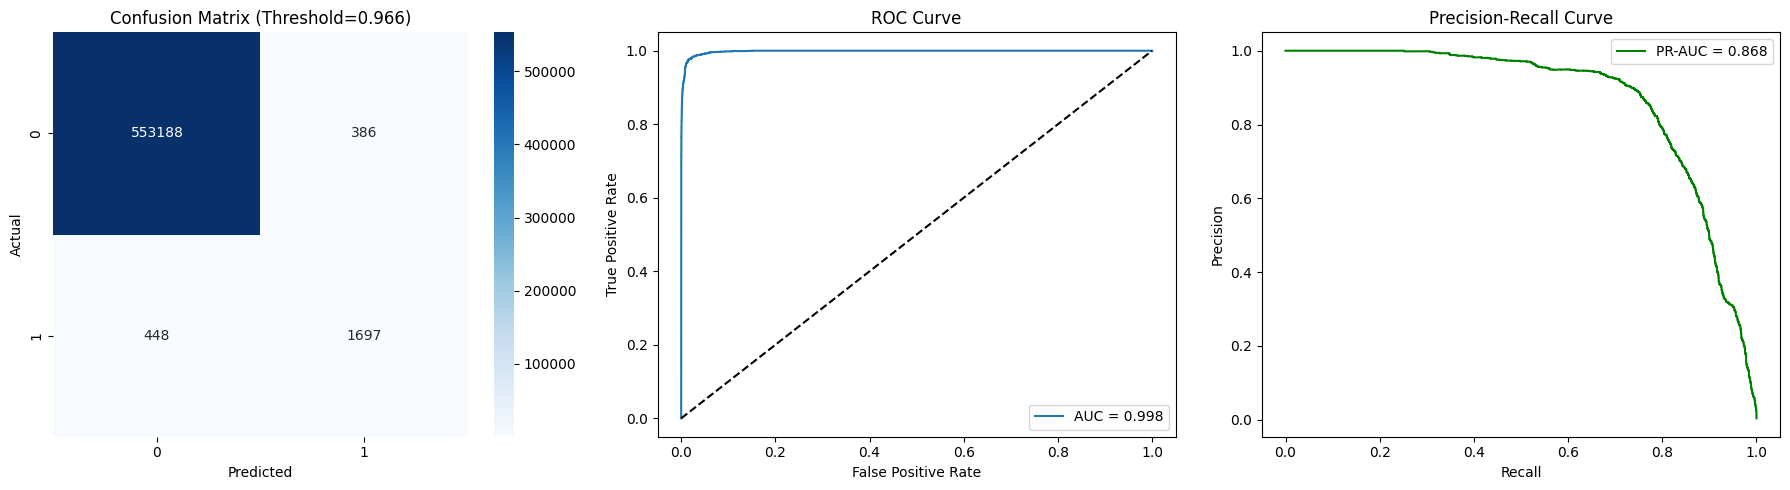

In [14]:
# ========================================================================
# 8. TEST ON NEW FILE (fraudTest.csv)
# ========================================================================
print("\n" + "="*60)
print("TESTING ON NEW FILE (fraudTest.csv)")
print("="*60)

test_file_path = 'fraudTest.csv'

try:
    # 8.1 Load Test Data
    print(f"Loading test data from {test_file_path}...")
    df_new_test = pd.read_csv(test_file_path)
    
    # 8.2 Preprocess Test Data
    # Lưu ý: Ta tái sử dụng hàm preprocess_data. 
    # Trong môi trường Production nghiêm ngặt, bạn nên lưu LabelEncoder từ bước train 
    # để transform cho test. Ở đây ta giả định các category (Gender, Job...) tương đồng.
    print("Preprocessing test data...")
    df_new_processed = preprocess_data(df_new_test)
    
    # Tách X, y
    if 'is_fraud' in df_new_processed.columns:
        X_new = df_new_processed.drop('is_fraud', axis=1)
        y_new = df_new_processed['is_fraud']
    else:
        X_new = df_new_processed
        y_new = None
        print("Note: 'is_fraud' column not found in test data. Skipping evaluation metrics.")
    
    # Đảm bảo thứ tự cột giống hệt lúc train (quan trọng cho XGBoost/LightGBM)
    # Nếu thiếu cột nào (do drop), code sẽ báo lỗi hoặc cần xử lý thêm
    X_new = X_new[X_train.columns]
    
    # 8.3 Predict using Trained Model
    print("Predicting on new data...")
    y_new_proba = model.predict_proba(X_new)[:, 1]
    
    # 8.4 Evaluate using the OPTIMAL THRESHOLD found earlier
    if y_new is not None:
        print(f"Evaluating using saved threshold: {optimal_threshold:.4f}")
        evaluate_performance(y_new, y_new_proba, threshold=optimal_threshold)
    else:
        print("Predictions generated (y_new_proba).")
        
except FileNotFoundError:
    print(f"Warning: File {test_file_path} not found. Skipping external test.")
except Exception as e:
    print(f"An error occurred during testing: {e}")
    import traceback
    traceback.print_exc()


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
             feature  importance
                 amt    0.210847
             amt_log    0.144427
            category    0.099784
   category_mean_amt    0.098773
amt_vs_category_mean    0.098379
                hour    0.087999
                 age    0.041931
          amt_zscore    0.035948
       card_mean_amt    0.035915
    card_trans_count    0.032157


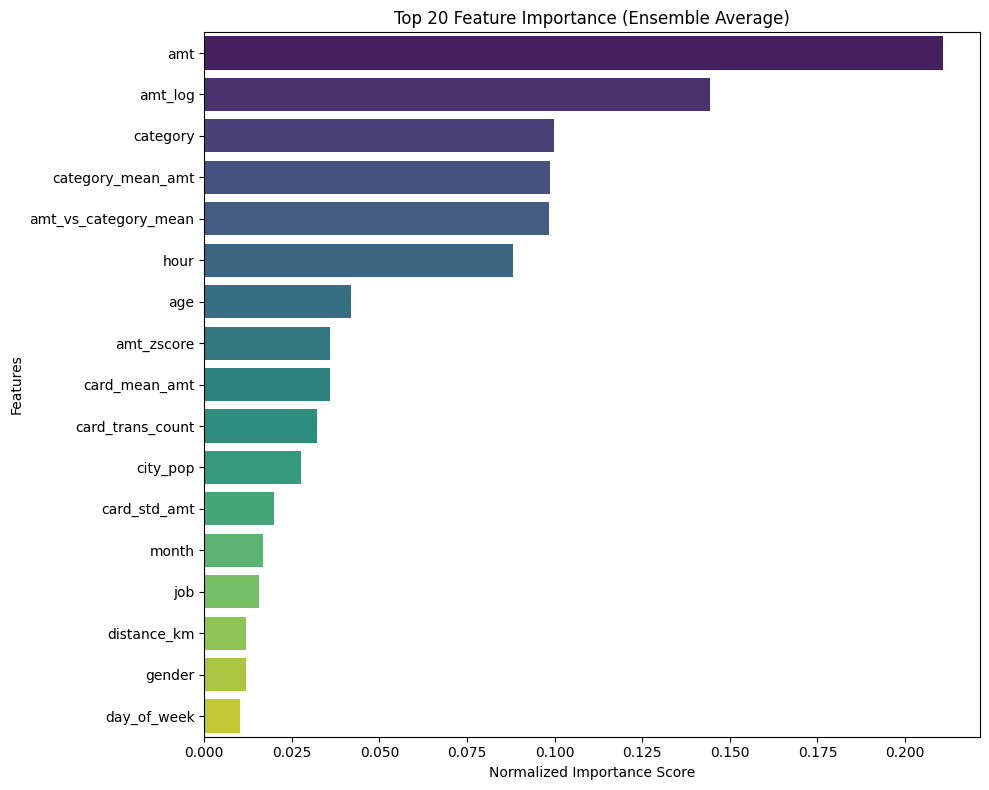

In [15]:
def plot_feature_importance(model, feature_names):
    """
    Trực quan hóa tầm quan trọng của các đặc trưng từ VotingClassifier
    bằng cách lấy trung bình từ các model con.
    """
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    # Lấy danh sách các model con đã được train
    estimators = model.estimators_
    
    importances_list = []
    
    for clf in estimators:
        # Kiểm tra xem model có thuộc tính feature_importances_ không
        if hasattr(clf, 'feature_importances_'):
            imp = clf.feature_importances_
            # Chuẩn hóa về thang đo 0-1 (vì CatBoost, LGBM có thể có thang đo khác nhau)
            if imp.sum() > 0:
                imp = imp / imp.sum()
            importances_list.append(imp)
            
    if not importances_list:
        print("Không thể trích xuất feature importance từ các model con.")
        return

    # Tính trung bình cộng độ quan trọng từ 3 model
    avg_importance = np.mean(importances_list, axis=0)
    
    # Tạo DataFrame để hiển thị
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_importance
    })
    
    # Sắp xếp giảm dần
    fi_df = fi_df.sort_values(by='importance', ascending=False)
    
    # In ra Top 10
    print("Top 10 Most Important Features:")
    print(fi_df.head(10).to_string(index=False))
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20), palette='viridis')
    plt.title('Top 20 Feature Importance (Ensemble Average)')
    plt.xlabel('Normalized Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_train.columns)